In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
import re

import sympy as sp

/var/folders/y8/698phn_j78qg7mclyy6h62r00000gn/T/ipykernel_75600/1318338482.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(f"{snapshot_df['sample'][0]} Device, {snapshot_df['comments'][0]}")
/Users/andrijapaurevic/opt/anaconda3/envs/opt_control/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fit function: exp_fit
Fit parameter(s): a = -4.598 nA, b = -0.003 1/mV, (x0,y0)=(489.75 mV,4.616 nA)


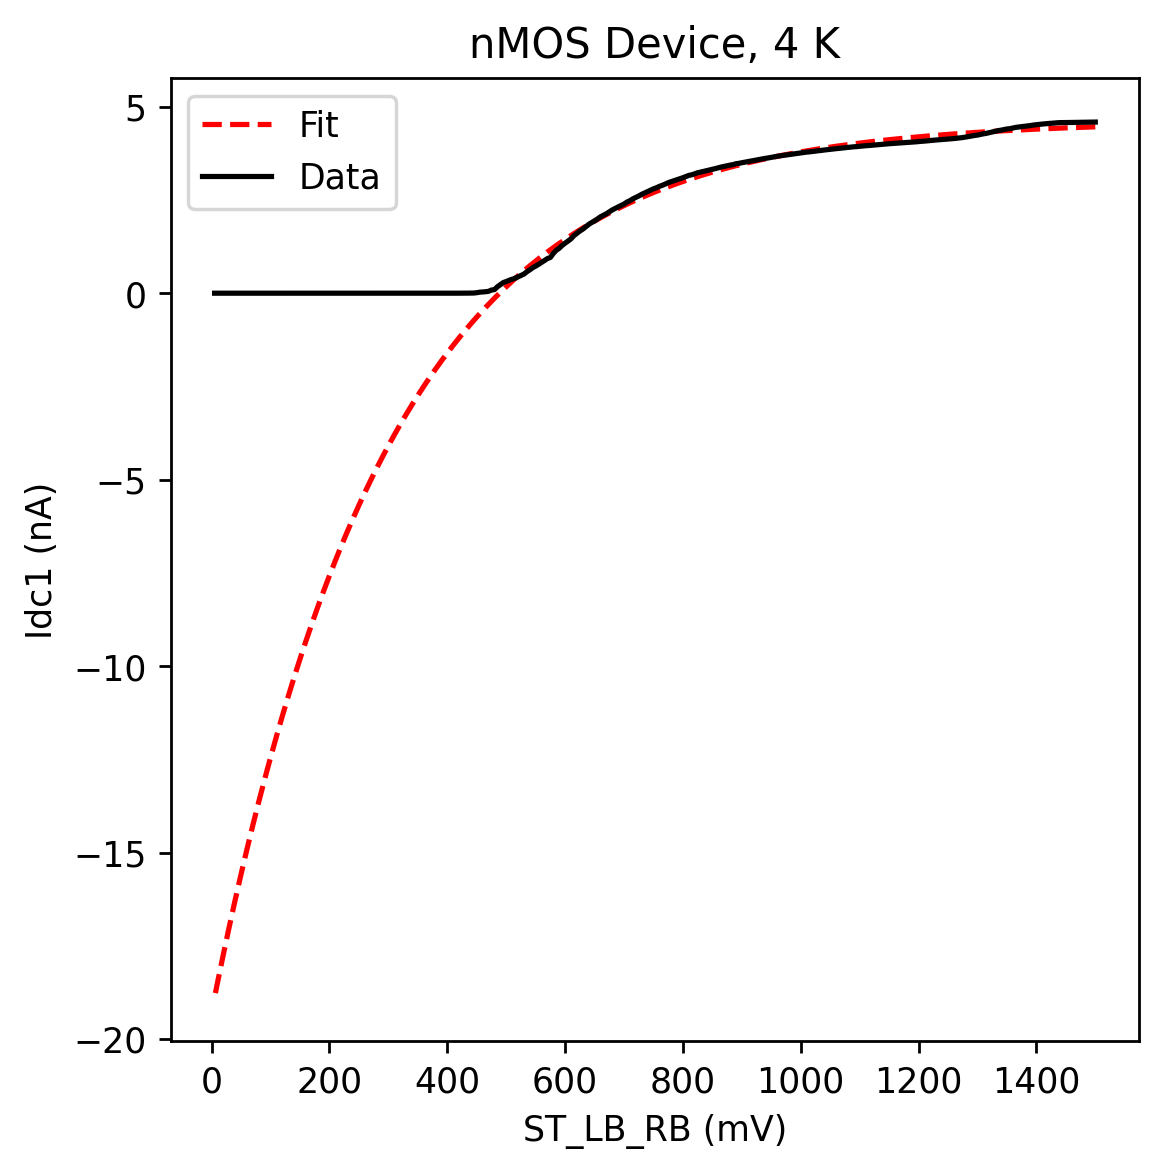

In [35]:
'''
Load in data, make sure to run this script in the same directory  
as your data!
'''
folder = "092242"
data_name = "data.dat"

# Save data as dataframe (easier to work with)
snapshot_json = pd.read_json(f"./data/{folder}/snapshot.json")
snapshot_df = pd.DataFrame(snapshot_json).replace(['#'],[''],regex=True)

# Load CSV into dataframe
data_csv = pd.read_csv(f"./data/{folder}/{data_name}", skiprows=[0,2], sep='\t')
data_df = pd.DataFrame(data_csv)

# Remove weird character artifacts found in names
data_df.columns = data_df.columns.str.replace('[#, ,"]','',regex=True)

# Read data see if theres a 1D or 2D sweep
vars = snapshot_df['loop_specs']
if 'step_id' in vars:
    X = [vars['step_id'], vars['sweep_id']]
else:
    X = [vars['sweep_id']]

is1DSweep = (len(X) == 1)
is2DSweep = (len(X) == 2)

Y = vars['output_id'][0]

# Fitting functions
def sigmoid_fit(x, a, b, x0, y0):
    return a/(1+np.exp(b * (x-x0))) + y0

def exp_fit(x, a, b, x0, y0):
    return a * np.exp(b * (x-x0)) + y0

def log_fit(x, a, b, x0, y0):
    return a * np.log(b * (x-x0)) + y0

def cosh_fit(x,a,b,x0,y0):
    return a * np.cosh(b * (x-x0))**-2 + y0

# Different plots
def isBarrierPinchOffScan(X):
    pattern1 = re.compile(r'LB')
    pattern2 = re.compile(r'RB')
    pattern3 = re.compile(r'ST')

    for item in X:
        if (pattern1.search(item) or pattern2.search(item)) and not(pattern3.search(item)):
            return True

    return False

def isScreeningGateScan(X):
    pattern1 = re.compile(r'C')

    for item in X:
        if pattern1.search(item):
            return True

    return False

def isLBRBScan(X):
    pattern1 = re.compile(r'LB')
    pattern2 = re.compile(r'RB')

    found_LB = False
    found_RB = False

    for item in X:
        if pattern1.search(item):
            found_LB = True
        if pattern2.search(item):
            found_RB = True

    return found_LB and found_RB

def isGlobalTurnOnScan(X):
    pattern1 = re.compile(r'LB')
    pattern2 = re.compile(r'RB')
    pattern3 = re.compile(r'ST')

    found_LB = False
    found_RB = False
    found_ST = False

    for item in X:
        if pattern1.search(item):
            found_LB = True
        if pattern2.search(item):
            found_RB = True
        if pattern3.search(item):
            found_ST = True

    return found_ST and found_LB and found_RB

def isCoulombDiamondScan(X):
    pattern1 = re.compile(r'ST')
    pattern2 = re.compile(r'VSD')

    found_ST = False
    found_VSD = False

    for item in X:
        if pattern1.search(item):
            found_ST = True
        if pattern2.search(item):
            found_VSD = True

    return found_ST and found_VSD

if is1DSweep:
    Y_units = snapshot_df['arrays'][f'keith1_{Y}']['unit']
    X_units = snapshot_df['arrays'][f'ivvi_{X[0]}_set']['unit']
    # Fit data accordingly
    if isBarrierPinchOffScan(X):
        f = sigmoid_fit
        X_thres, Y_thres = data_df[X[0]], data_df[Y]
        guess = (1,0.2,1,1)
        fit_function = True
        
    elif isGlobalTurnOnScan(X):
        f = exp_fit
        mask = data_df[Y] > 1e-1 # arbitrary current value, change if needed
        X_thres = data_df[X[0]][mask]
        Y_thres = data_df[Y][mask]
        guess = (-max(Y_thres), -1, min(X_thres), max(Y_thres))
        fit_function = True

    elif isScreeningGateScan(X):
        f = sigmoid_fit
        X_thres, Y_thres = data_df[X[0]], data_df[Y]
        guess = (1,0.2,1,0)
        fit_function = True

    plt.figure(dpi=250, figsize=(5,5))
    plt.title(f"{snapshot_df['sample'][0]} Device, {snapshot_df['comments'][0]}")

    if fit_function:
        fit_params, fit_cov = curve_fit(f, X_thres, Y_thres, guess)
        a, b, x0, y0 = fit_params
        plt.plot(data_df[X], f(data_df[X], a,b,x0,y0), 'r--', label='Fit')

        print(f"Fit function: {f.__name__}")
        print(f"Fit parameter(s): a = {round(a,3)} {Y_units}, b = {round(b,3)} 1/{X_units}, (x0,y0)=({round(x0,3)} {X_units},{round(y0,3)} {Y_units})")
        if "sigmoid" in f.__name__:
            print(f"Width of sigmoid: {round(np.sqrt(8)/b,3)} {X_units}")
        if "cosh" in f.__name__:
            print(f"Width of peak: {round(b,3)} {X_units}")

    plt.plot(data_df[X], data_df[Y], 'k', label='Data')
    plt.ylabel(f"{Y} ({Y_units})")
    plt.xlabel(f"{X[0]} ({X_units})")
    plt.legend(loc='best')
    plt.show()

if is2DSweep:
    # Get X1 and X2 of the graph
    X1 = np.unique(np.array(data_df[X[0]]))
    minX1, maxX1 = np.min(X1), np.max(X1)
    X2 = np.unique(np.array(data_df[X[1]]))
    minX2, maxX2 = np.min(X2), np.max(X2)
    X1 = X1[~np.isnan(X1)]
    X2 = X2[~np.isnan(X2)]

    Y = np.array(data_df[Y])

    Y = Y[~np.isnan(Y)].reshape(len(X1), len(X2))


    if isCoulombDiamondScan(X):
        plt.figure(dpi=250, figsize=(5,5))
        plt.title(f"Coulomb Diamonds, {snapshot_df['sample'][0]} Device, {snapshot_df['comments'][0]}")
        plt.imshow(np.rot90(Y),origin='lower',aspect='auto',extent=[minX1, maxX1, minX2, maxX2])
        plt.ylabel(f"{X[1]} ({snapshot_df['arrays'][f'ivvi_{X[0]}_set']['unit']})")
        plt.xlabel(f"{X[0]} ({snapshot_df['arrays'][f'ivvi_{X[1]}_set']['unit']})")
        plt.show()

    if isLBRBScan(X):
        plt.figure(dpi=250, figsize=(5,5))
        plt.title(f"Coulomb Diamonds, {snapshot_df['sample'][0]} Device, {snapshot_df['comments'][0]}")
        plt.imshow(np.rot90(Y),origin='lower',aspect='auto',extent=[minX1, maxX1, minX2, maxX2])
        plt.ylabel(f"{X[1]} ({snapshot_df['arrays'][f'ivvi_{X[0]}_set']['unit']})")
        plt.xlabel(f"{X[0]} ({snapshot_df['arrays'][f'ivvi_{X[1]}_set']['unit']})")
        plt.show()




# Coulomb Diamond Stuff

https://theses.hal.science/tel-00131052/document

In [36]:
folder = "14-07-09_sweep2D_SDPvsV_SD_1"
data_name = "hallbar_V_SD_1_set_gates_SDP_set.dat"
# folder = "130610"
# data_name = "data.dat"

# Load snapshot information
# into a dataframe (easier to process)
snapshot_json = pd.read_json(f"./Data/{folder}/snapshot.json")
snapshot_df = pd.DataFrame(snapshot_json).replace(['#'],[''],regex=True)

# Load CSV into dataframe
data_csv = pd.read_csv(f"./Data/{folder}/{data_name}", skiprows=[0,2], sep='\t')
data_df = pd.DataFrame(data_csv)

# Remove artifacts
data_df.columns = data_df.columns.str.replace('[#, ,"]','',regex=True)

# VSD_labels = data_df.filter(regex=f'(?i)V[_]?SD$', axis=1).columns
# VST_labels = data_df.filter(regex=f'(?i)V[_]?SD$', axis=1).columns
ISD_labels = data_df.filter(regex=f'/Isd_DC/i', axis=1).columns
print(ISD_labels)

print(data_df)

Index([], dtype='object')
       V_SD    SDP       SDP.1        Isd_DC       V_SD_1
0         0  260.0  259.983215  1.714112e-11    -0.030518
1         0  260.1  260.105287  1.724798e-11    -0.030518
2         0  260.2  260.227359  1.722036e-11    -0.030518
3         0  260.3  260.288396  1.733205e-11    -0.030518
4         0  260.4  260.410468  1.726977e-11    -0.030518
...     ...    ...         ...           ...          ...
89995  1480  379.5  379.491875  2.629561e-09  1479.972534
89996  1480  379.6  379.613947  2.680789e-09  1479.972534
89997  1480  379.7  379.674983  2.651275e-09  1479.972534
89998  1480  379.8  379.797055  2.683555e-09  1479.972534
89999  1480  379.9  379.919127  2.713954e-09  1479.972534

[90000 rows x 5 columns]


In [37]:

def sigmoid_fit(x, a, b, x0, y0):
    return a/(1+np.exp(b * (x-x0))) + y0

def exp_fit(x, a, b, x0, y0):
    return a * np.exp(b * (x-x0)) + y0

def log_fit(x, a, b, x0, y0):
    return a * np.log(b * (x-x0)) + y0




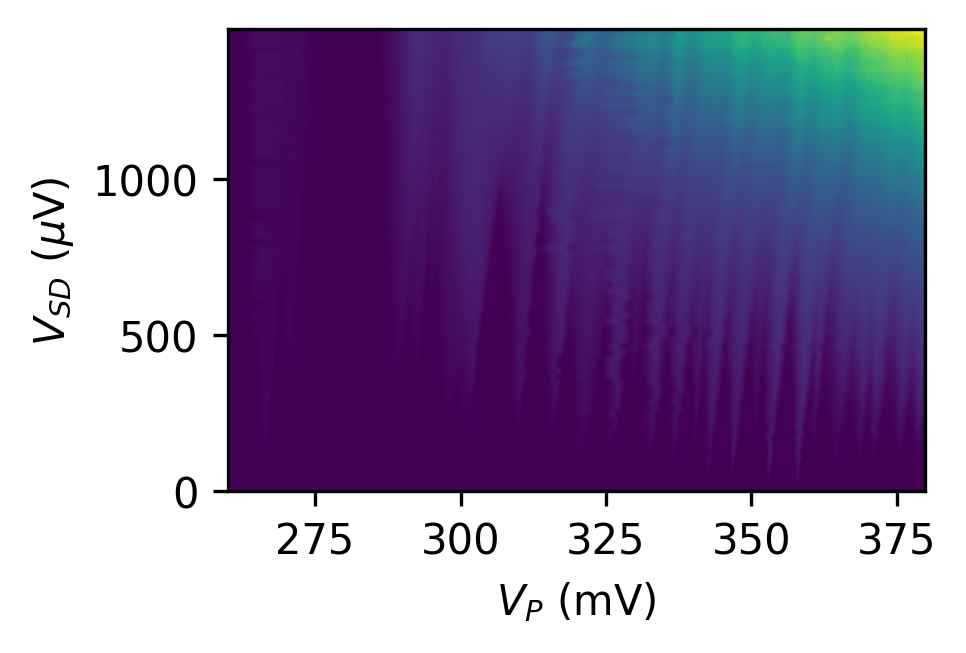

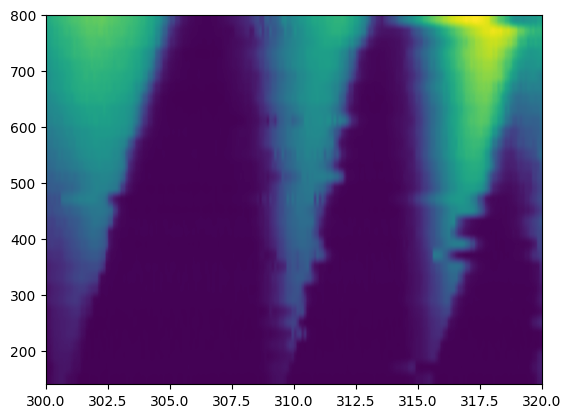

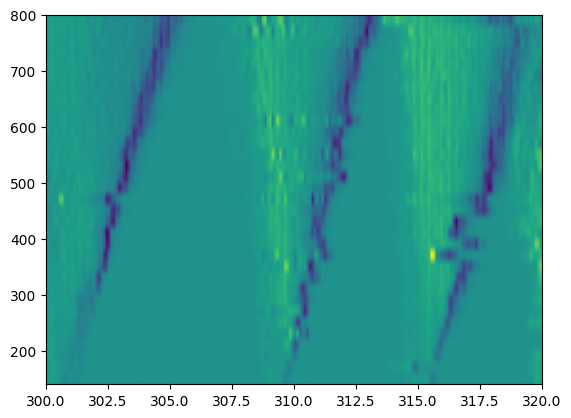

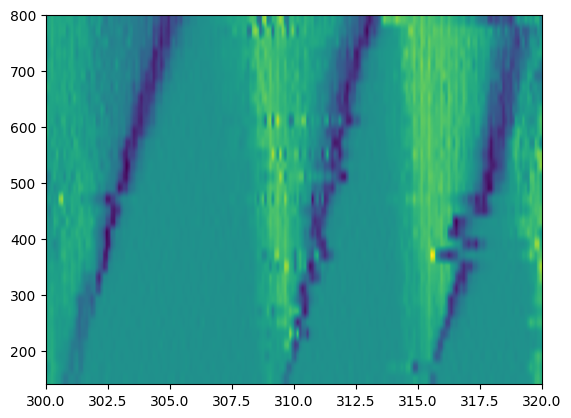

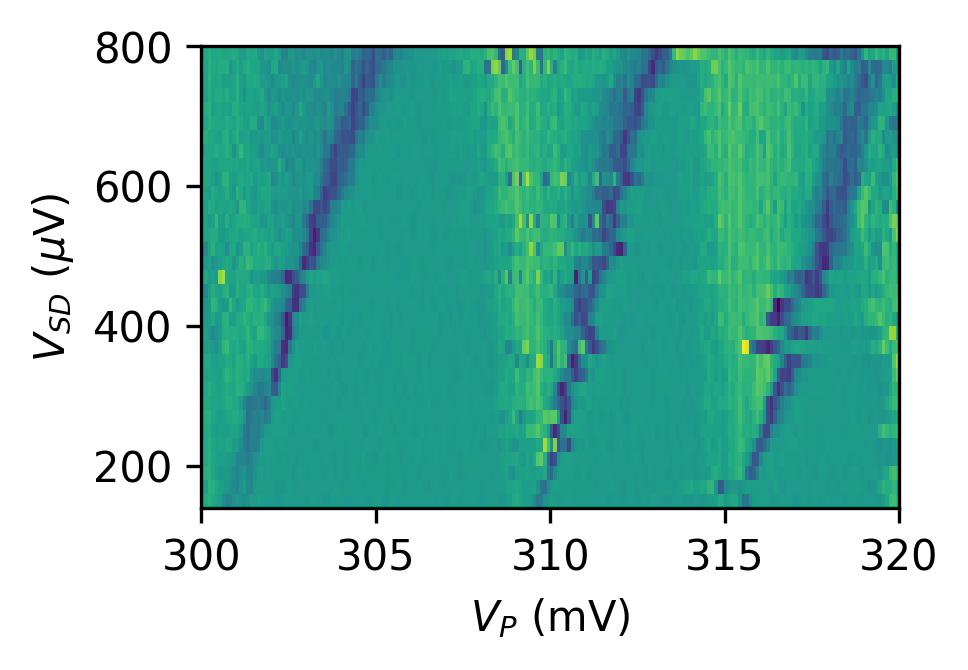

In [38]:

# vars = snapshot_df['loop_specs']
# if 'step_id' in vars:
#     X = [vars['step_id'], vars['sweep_id']]
# else:
#     X = vars['sweep_id']

# Y = vars['output_id'][0]

X1 = "SDP"
X2 = "V_SD_1"
Y = "Isd_DC"
X =X1
if not(isinstance(X,str)):

    if X in ['LB', 'RB']:
        f = sigmoid_fit
        X_thres, Y_thres = data_df[X], data_df[Y]
        guess = (1,1,1,1)
        
    elif X == 'ST_LB_RB':
        f = exp_fit
        mask = data_df[Y] > 1e-1
        X_thres = data_df[X][mask]
        Y_thres = data_df[Y][mask]
        guess = (-max(Y_thres), -1, min(X_thres), max(Y_thres))

    plt.figure(dpi=200, figsize=(5,5))
    plt.title(f"{snapshot_df['sample'][0]} Device, {snapshot_df['comments'][0]}")

    fit_params, fit_cov = curve_fit(f, X_thres, Y_thres, guess)
    a, b, x0, y0 = fit_params
    plt.plot(X_thres, f(X_thres, a, b, x0, y0), 'r--',label=r'Fit')

    plt.plot(data_df[X], data_df[Y], 'k', label=r'Data')
    plt.ylabel(f"{Y} ({snapshot_df['arrays'][f'keith1_{Y}']['unit']})")
    plt.xlabel(f"{X} ({snapshot_df['arrays'][f'ivvi_{X}_set']['unit']})")
    plt.legend(loc='best')
    plt.show()

else:
    cond_quant = 3.25 * 1e-5
    G0 = 1e-3 * cond_quant
    from scipy.ndimage import convolve
    def U(x,y):
        sigX, sigY = 5,5
        return (1/(2 * np.pi * sigX * sigY)) * np.exp(- 0.5* ((x/sigX)**2 + (y/sigY)**2))
    def adjusted(G,G0=G0):
        return np.sign(G) * np.log((np.abs(G)/G0) + 1)
    def F(U, G,G0=G0):
        # G = adjusted(G,G0)
        return (G - convolve(G,U)) / np.sqrt((convolve(G,U))**2 + G0**2)

    plt.figure(dpi=300, figsize=(3,2))

    I_OG = np.array(data_df[str(Y)]).reshape(75,1200)
    x = np.unique(np.array(data_df[X1]))
    y = np.unique(np.array(data_df[X2]))
    plt.imshow(I_OG, origin='lower',aspect='auto', extent=[np.min(x), np.max(x), np.min(y), np.max(y)])
    # plt.title("Coloumb Diamonds")
    plt.xlabel(r"$V_{P}$ (mV)")
    plt.ylabel(r"$V_{SD}$ ($\mu$V)")
    plt.show()

    min_h_index, max_h_index = 7, 40
    min_v_index, max_v_index = -800, -600
    I = I_OG[min_h_index:max_h_index,min_v_index:max_v_index]
# 

    plt.imshow(I, origin='lower',aspect='auto', extent=[x[min_v_index], x[max_v_index], y[min_h_index], y[max_h_index]])
    # plt.colorbar()
    plt.show()
    # plt.figure(dpi=300, figsize=(5,5))

    G = 0* np.gradient(I)[0] +1 * np.gradient(I)[1]
    plt.imshow(G,
            origin='lower',aspect='auto',extent=[x[min_v_index], x[max_v_index], y[min_h_index], y[max_h_index]])

    plt.show()
    G_adjusted = adjusted(G,G0=1e-11)
    plt.imshow(G_adjusted,
            origin='lower',aspect='auto', extent=[x[min_v_index], x[max_v_index], y[min_h_index], y[max_h_index]])
    # plt.colorbar()
    plt.show()

    N = 9
    U_kernal = np.array([[U(x, y) for y in range(-(N-1)//2,(N-1)//2 + 1)] for x in range(-(N-1)//2,(N-1)//2 + 1)])
    plt.figure(dpi=300, figsize=(3,2))
    G_filtered = F(U_kernal,G_adjusted,G0=1)
    plt.imshow(G_filtered,
            origin='lower',aspect='auto', extent=[x[min_v_index], x[max_v_index], y[min_h_index], y[max_h_index]])

    # plt.title("Coloumb Diamonds")
    plt.xlabel(r"$V_{P}$ (mV)")
    plt.ylabel(r"$V_{SD}$ ($\mu$V)")
    plt.show()

    plt.show()

In [39]:
def calculate_inverse_reciprocal_sum(pair):
    x1, slope1 = pair[0]
    x2, slope2 = pair[1]

    # Calculate the inverse reciprocal sum
    inverse_reciprocal_sum = np.abs(1 / slope1) + np.abs(1 / slope2)

    return 1/ inverse_reciprocal_sum

def cluster_x_intercepts(lines_dict):
    intercepts = list(lines_dict.keys())
    slopes = list(lines_dict.values())
    
    intercept_pairs = []

    for i in range(len(intercepts)):
        for j in range(i + 1, len(intercepts)):
            x_intercept1, x_intercept2 = intercepts[i], intercepts[j]
            slope1, slope2 = slopes[i], slopes[j]
            intercept_pairs.append(((x_intercept1, slope1), (x_intercept2, slope2)))

    # Sort the pairs based on the difference in x-intercepts
    intercept_pairs.sort(key=lambda pair: abs(pair[0][0] - pair[1][0]))

    # Take the first N pairs (N = number of clusters)
    num_clusters = len(intercepts) // 2
    closest_pairs = intercept_pairs[:num_clusters]

    # Calculate the inverse reciprocal sum for each pair
    inverse_reciprocal_sums = [calculate_inverse_reciprocal_sum(pair) for pair in closest_pairs]

    return closest_pairs, inverse_reciprocal_sums



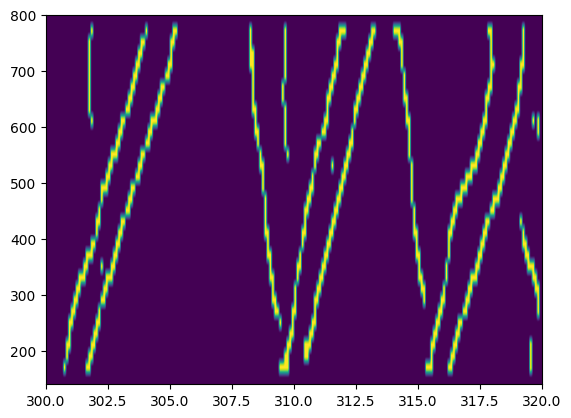

[((161, 0.16001220721751724), (154, -0.5333740240583908)), ((103, 0.21623271245610506), (94, -0.4706241388750539))] [0.12308631324424404, 0.14815945112733145]


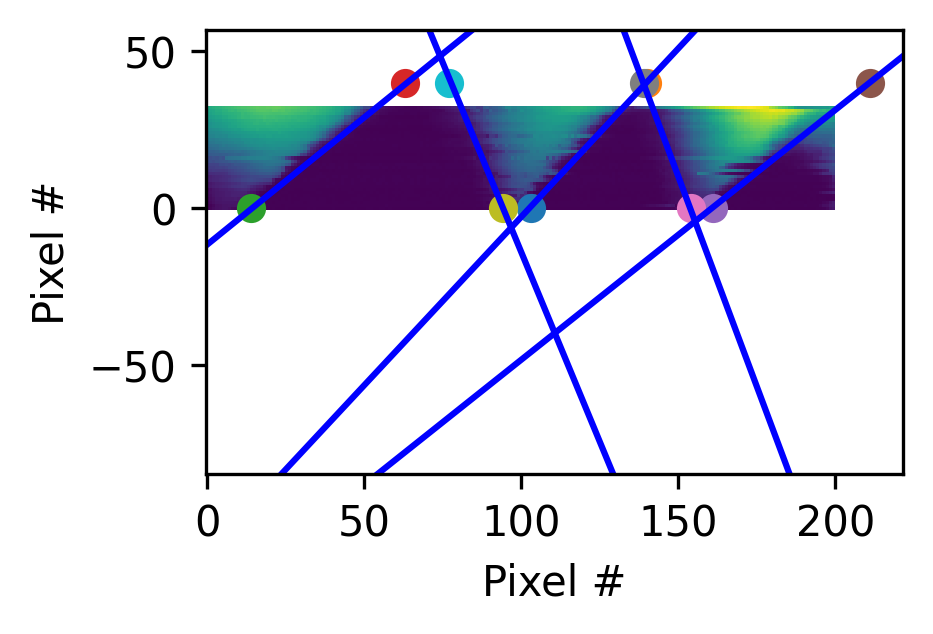

In [40]:
import skimage
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data

edges = canny(G_adjusted,sigma=3)

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
plt.imshow(edges,
            origin='lower',aspect='auto',extent=[x[min_v_index], x[max_v_index], y[min_h_index], y[max_h_index]])
plt.show()
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(edges, theta=tested_angles)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

plt.figure(dpi=300, figsize=(3,2))

plt.imshow(I,origin='lower')

# 
# plt.title('Detected lines')

lines_dict = {}
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    if np.tan(angle + np.pi/2) > 5 or np.abs(np.tan(angle + np.pi/2)) < 0.7:
        continue
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])

    plt.axline((x0, y0), slope=np.tan(angle + np.pi/2),c='b')
    def x_intercept(point, slope):
        x_0, y_0 = point
        x_intercept_value = x_0 - y_0 / slope
        return x_intercept_value
    x_int_index = round(x_intercept([x0,y0],np.tan(angle + np.pi/2)))
    x_int = x[min_v_index + round(x_intercept([x0,y0],np.tan(angle + np.pi/2)))]
    slope =np.tan(angle + np.pi/2)

    P_x_int = [x_int_index, 0]
    P = [round(max_h_index/ slope + x_int_index), max_h_index]
    plt.scatter([x_int_index], [0])
    plt.scatter([round(max_h_index/ slope + x_int_index)], [max_h_index])
    true_slope = (1e-6*(y[P[1]] - y[P_x_int[1]] ))/ (1e-3*(x[min_v_index + P[0]] - x[min_v_index + P_x_int[0]]))

    lines_dict[x_int_index] = true_slope 

result, inverse_reciprocal_sums = cluster_x_intercepts(lines_dict)
print(result, inverse_reciprocal_sums)
plt.xlabel("Pixel #")
plt.ylabel("Pixel #")
plt.show()
# print(slopes)
# binwidth = 0.01
# plt.hist(slopes, bins=np.arange(min(slopes), max(slopes) + binwidth, binwidth))
# plt.show()

SD is 139.986266880293
VP that gives max conductance : 357.7


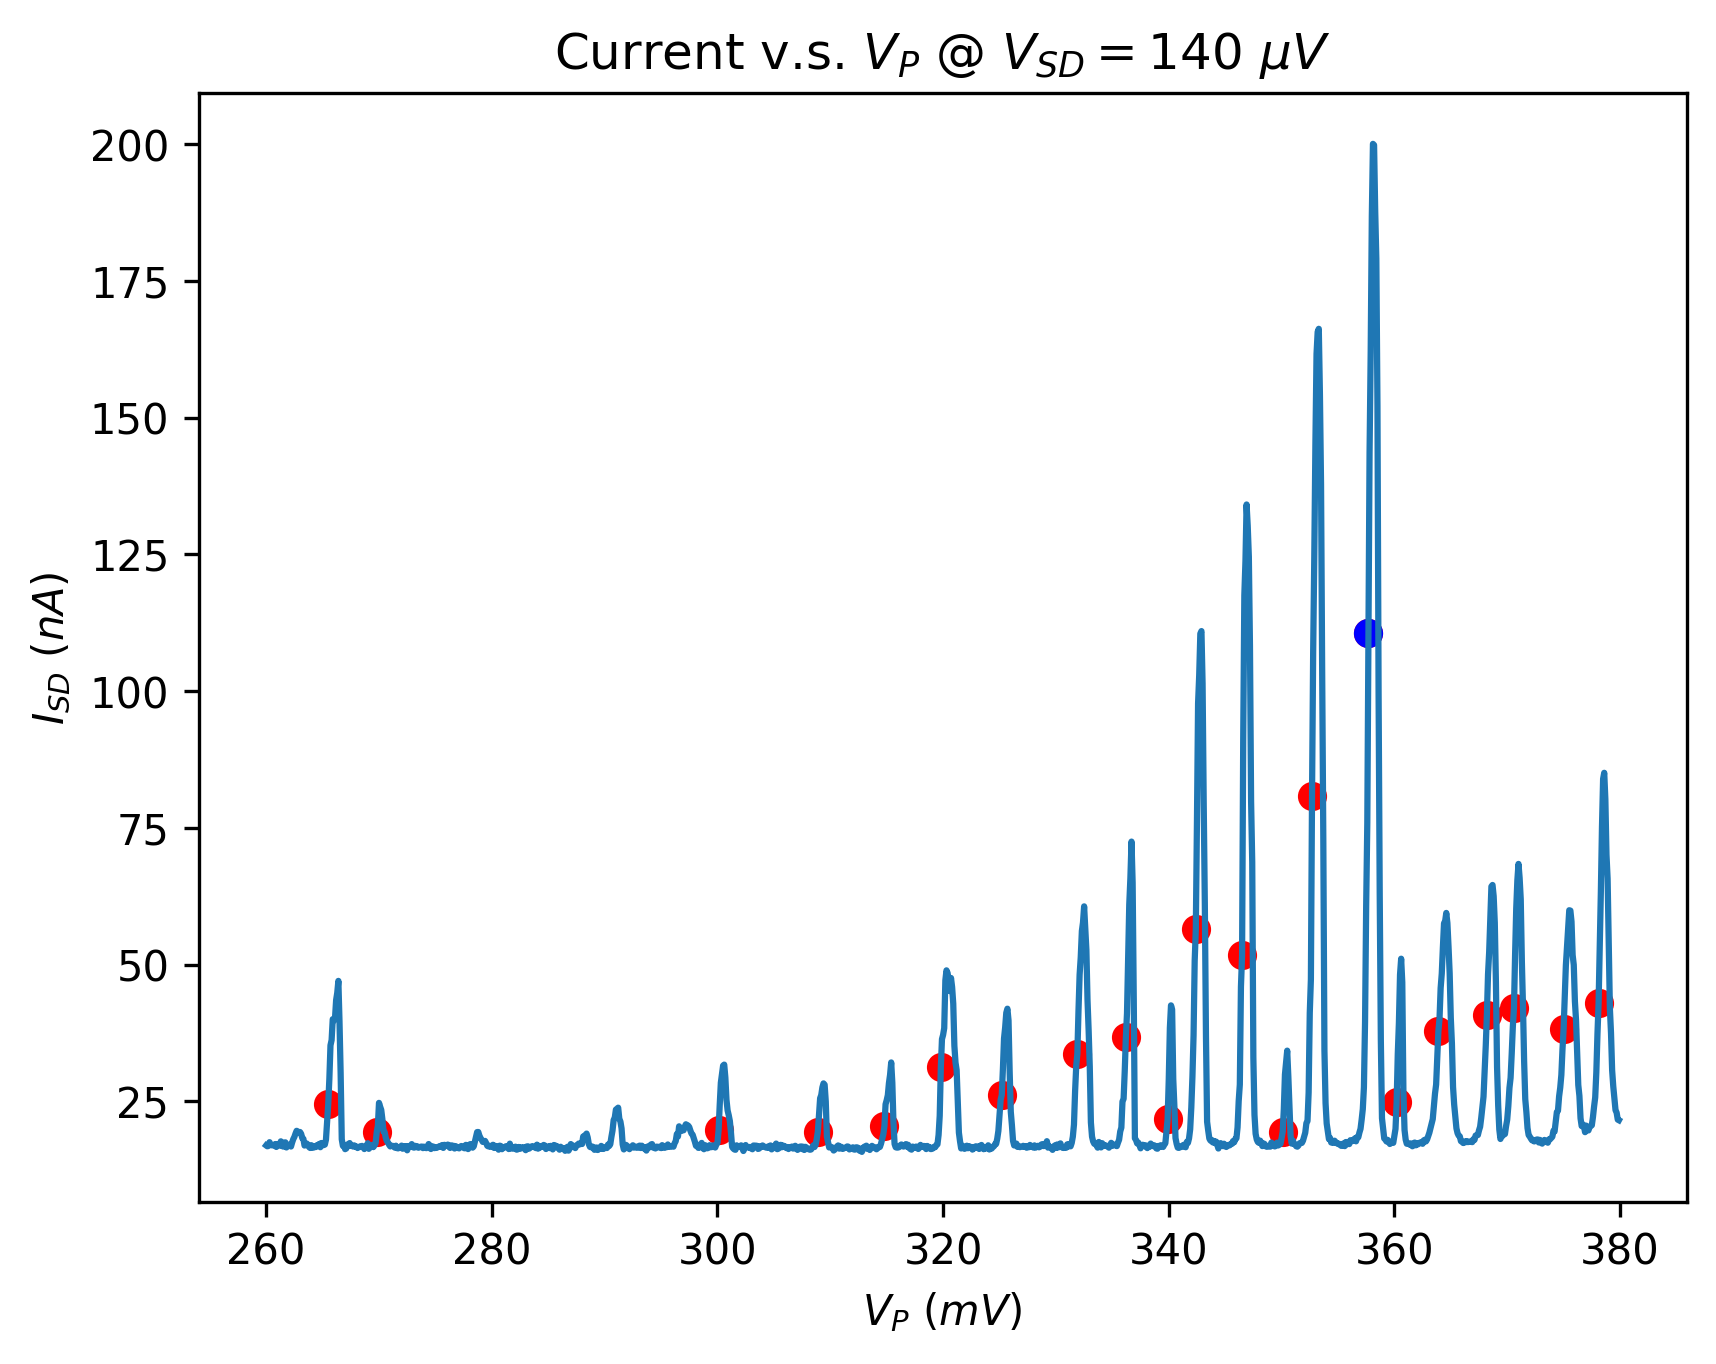

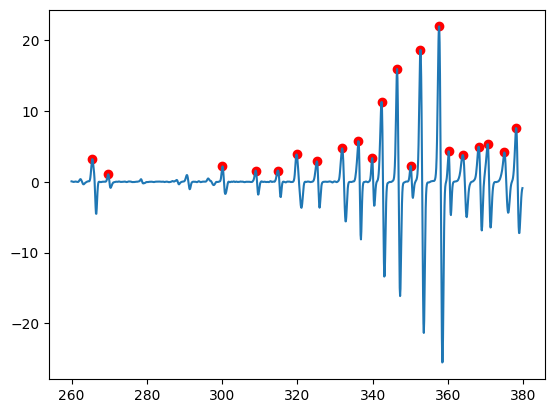

In [41]:
from scipy.misc import derivative
import scipy
from scipy.signal import argrelextrema

ISD = I_OG[7,:]/1e-12
print(f"SD is {y[7]}")
ISD_filter = scipy.ndimage.gaussian_filter1d(ISD, sigma= 1)

G =np.diff(ISD_filter)
G = scipy.ndimage.gaussian_filter1d(G, sigma= 2)

# Find local maxima using the `argrelextrema` function from scipy
maxima = argrelextrema(G, np.greater)[0]

maxima_filter =maxima[G[maxima] >= 1]

max_Gs = G[maxima_filter]

max_VP_index = maxima_filter[np.argmax(max_Gs)]

max_VP = x[max_VP_index]
print(f"VP that gives max conductance : {max_VP}")

plt.figure(dpi=300)
plt.title(r"Current v.s. $V_P$ @ $V_{SD} = "+f"{round(y[7])}"+r"\ \mu V$")
plt.ylabel(r"$I_{SD}\ (nA)$")
plt.xlabel(r"$V_{P}\ (mV)$")
plt.plot(x,ISD)
plt.scatter(x[maxima_filter], ISD[maxima_filter], c='r', label='Local Maxima')
plt.scatter(max_VP, ISD[max_VP_index], c='b')
plt.show()
plt.plot(x[:-1], G)
plt.scatter(x[maxima_filter], G[maxima_filter], c='r')
plt.show()



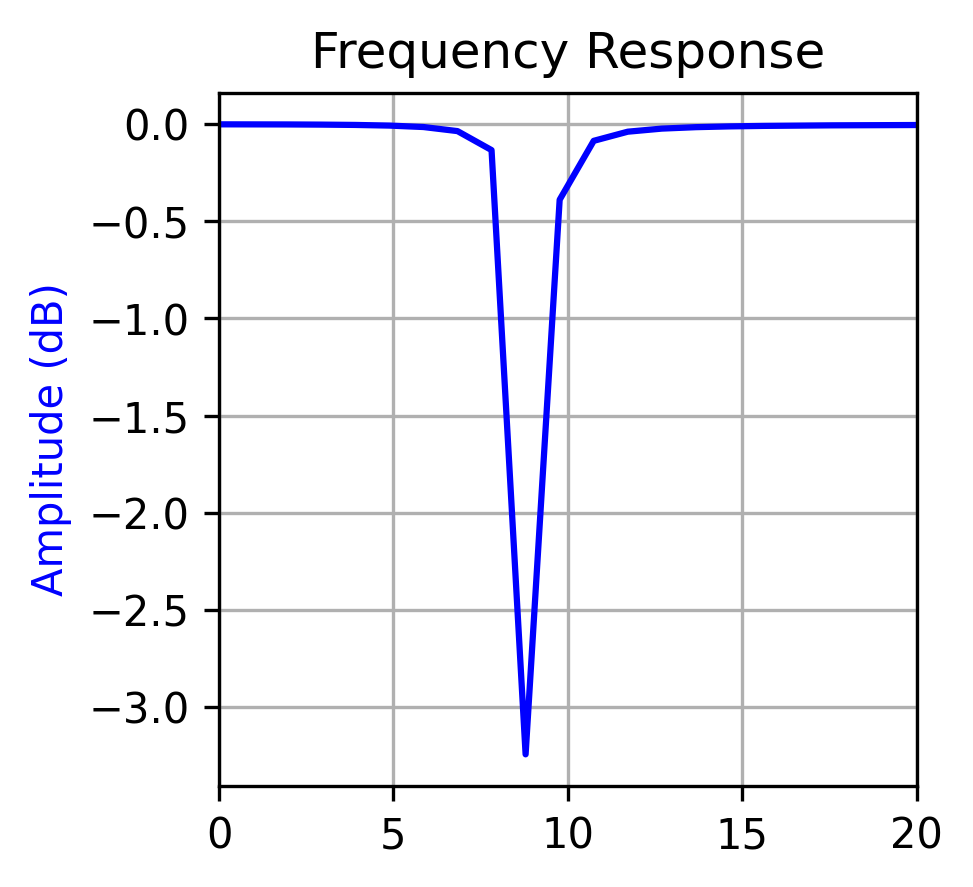

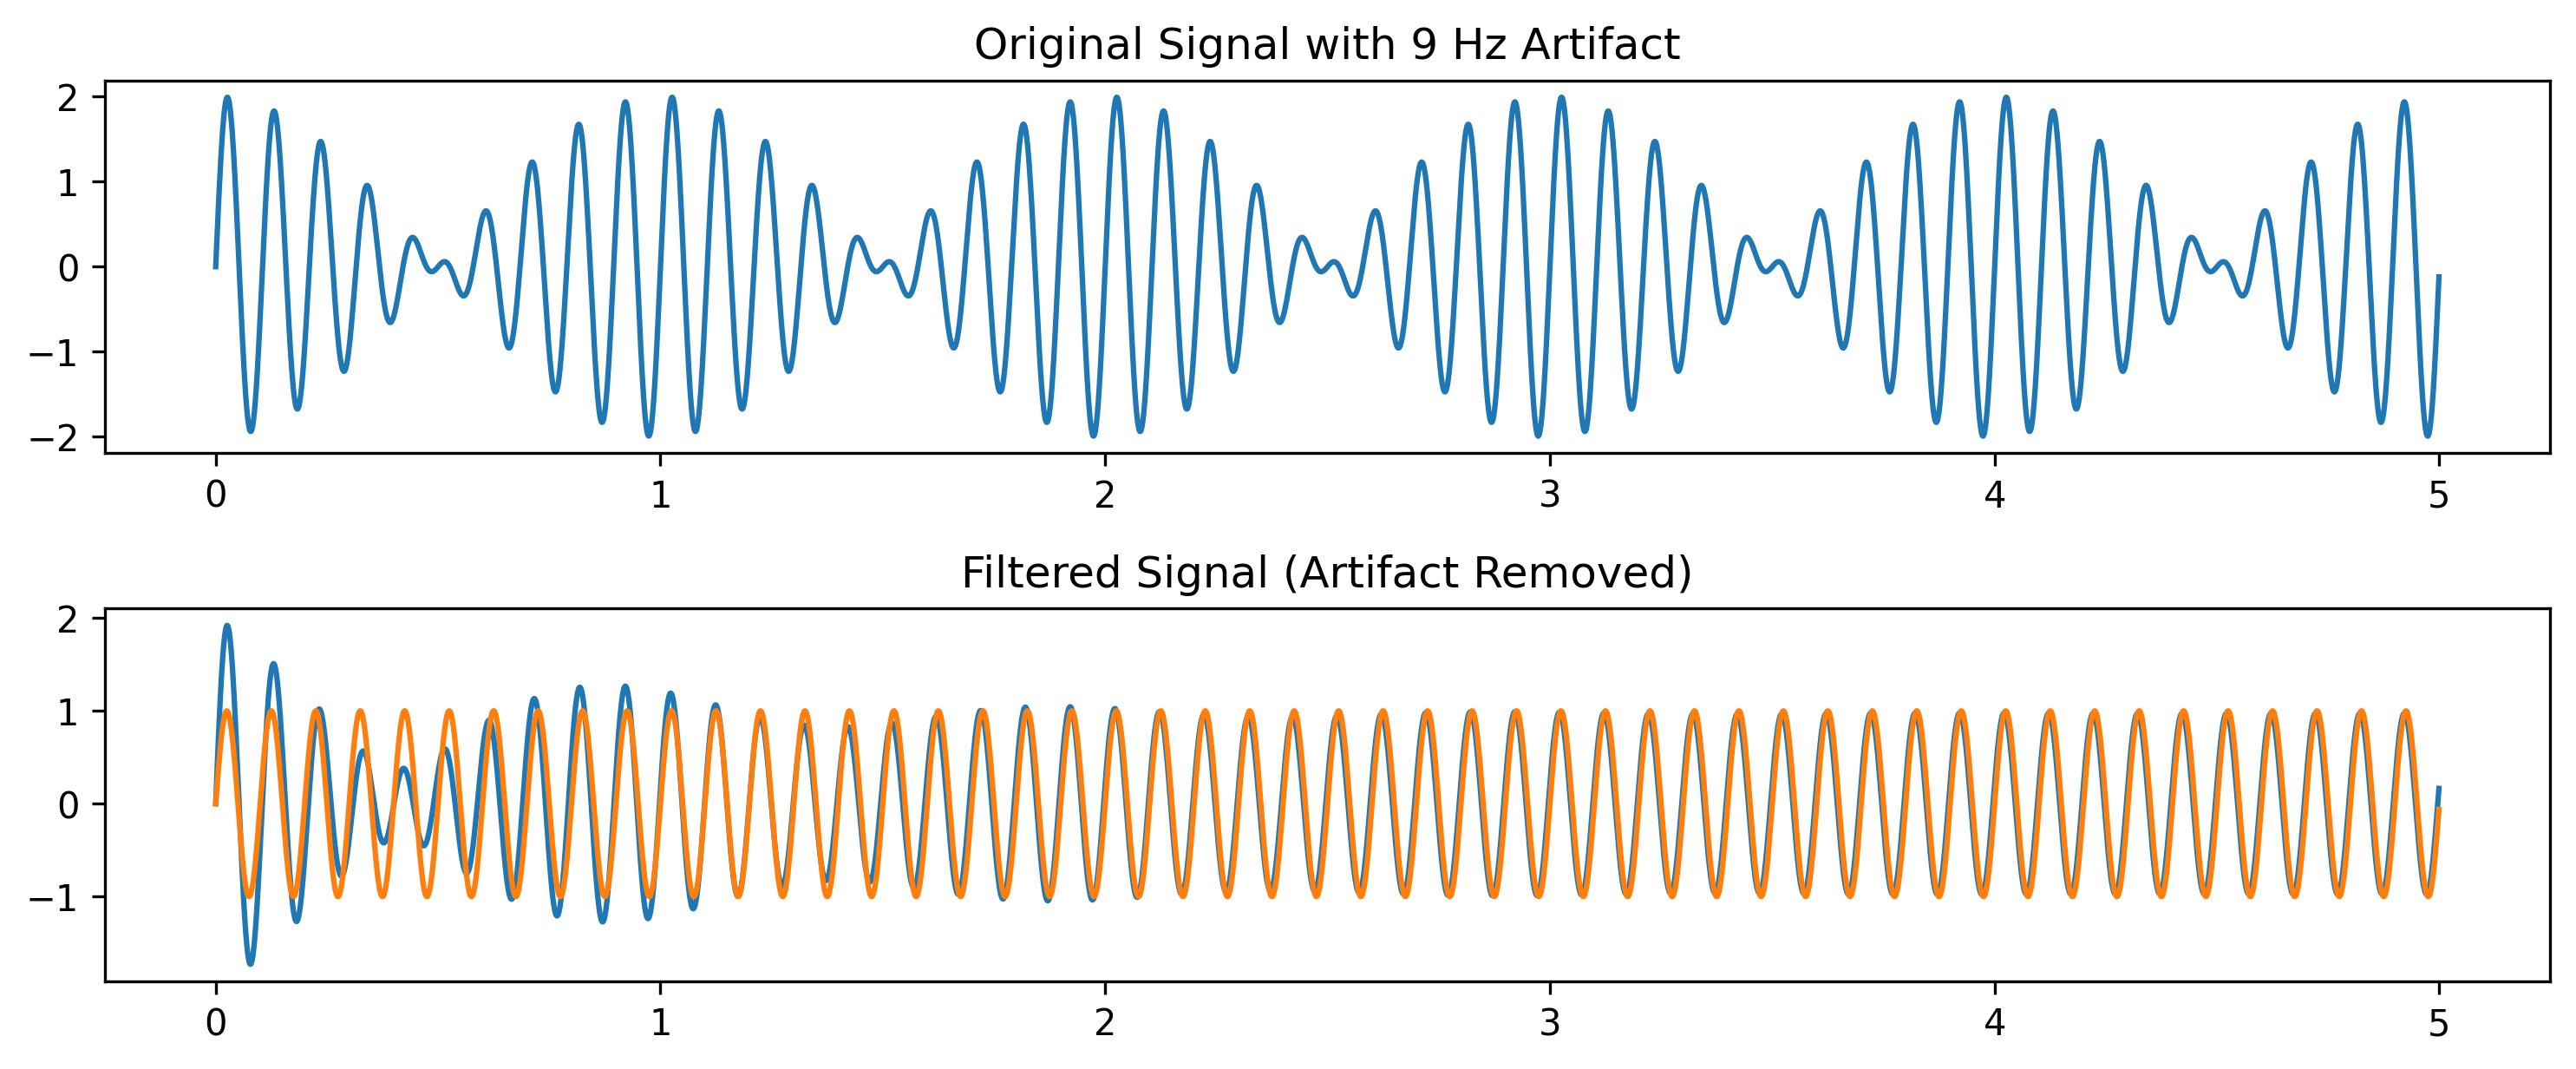

In [42]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def remove_9hz_artifact(signal_data, sampling_rate):
    # Define the notch filter parameters to remove the 9 Hz artifact
    center_freq = 9.0  # Frequency to remove (in Hz)
    q_factor = 20 # Quality factor of the notch filter

    # Design the notch filter
    b, a = signal.iirnotch(center_freq, Q=q_factor, fs=sampling_rate)
    # Frequency response
    freq, h = signal.freqz(b, a, fs=sampling_rate)
    # Plot
    plt.figure(dpi=300, figsize=(3,3))

    plt.plot(freq, 20*np.log10(abs(h)), color='blue')
    plt.title("Frequency Response")
    plt.ylabel("Amplitude (dB)", color='blue')
    plt.xlim([0, 20])
    plt.grid(True)
    plt.show()
        # Apply the notch filter to the signal
    filtered_signal = signal.lfilter(b, a, signal_data)

    return filtered_signal

# Create a synthetic signal with a 9 Hz artifact
fs = 1000  # Sampling rate in Hz
t = np.arange(0, 5, 1/fs)  # Time vector from 0 to 5 seconds
original_signal = np.sin(2 * np.pi * 9 * t) + np.sin(2 * np.pi * 10 * t)

# Apply the function to remove the 9 Hz artifact
filtered_signal = remove_9hz_artifact(original_signal, fs)

# Plot the original and filtered signals
plt.figure(dpi=300, figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(t, original_signal)
plt.title("Original Signal with 9 Hz Artifact")
plt.subplot(3, 1, 2)
plt.plot(t, filtered_signal)
plt.title("Filtered Signal (Artifact Removed)")
plt.subplot(3, 1, 2)

plt.plot(t, np.sin(2 * np.pi * 10 * t))
plt.title("Filtered Signal (Artifact Removed)")

plt.tight_layout()
plt.show()
